In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
h  = 6.62607015e-34      # Planck constant, J/Hz
c = 299792458.0          # speed of light, m/s
J_eV = 1.602176565e-19   # J per eV conversion

def get_wavelen(energy):
    # energy in keV -> returns wavelength in mm
    return h*c/(energy*J_eV)

In [3]:
# plot style

plt.rcParams.update({
    # figure
    "figure.dpi": 150, #300,   # higher quality image
    # text
    "font.size":10,
    "font.family": "serif",                  # uncomment for tex style
    "font.serif": ['Computer Modern Roman'], # uncomment for tex style
    "text.usetex": True,                     # uncomment for tex style
    # axes
    "axes.titlesize": 10,
    "axes.labelsize": 8,
    "axes.linewidth": 1,
    # ticks
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    # grid
    "axes.grid" : False,
    "axes.grid.which" : "major",
     "grid.color": "lightgray",
     "grid.linestyle": ":",
     # legend
     "legend.fontsize":8,
    "legend.facecolor":'white',
    "legend.framealpha":1.0 ,  
    # image
    "image.cmap":"gray",
     })


# X-ray field forward model

We model the X-ray field $f$ propagation in three stages: incident (I) -> exiting the object (O) -> reaching the detector (D), with each stage notated with subscripts: $f_I(u,v) \rightarrow f_O(u,v) \rightarrow f_D(u,v)$.

## Notes from Mohan et al.

Source: Mohan, K. Aditya, Jean-Baptiste Forien, Venkatesh Sridhar, Jefferson A. Cuadra, and Dilworth Parkinson. "Non-Linear Phase-Retrieval Algorithms for X-ray Propagation-Based Phase-Contrast Tomography." arXiv preprint arXiv:2305.00334 (2023).

### $f_I$: incident field

Consider a plane wave $f_I(u,v)$ of wavelength $\lambda$ directed along the $w$-axis. We assume that it has a constant phase of zero. This is without loss of generality, since the detector is only sensitive to X-ray field in intensity and any information on constant phase terms is lost.

### $f_O$: modulation through an object

Consider an an object with complex refractive index $n(u,v,w) = 1 - \delta(u,v,w) + i\beta(u,v,w)$. If we ignore constant phase terms (from Jacobsen p 93, I believe this is a time-dependent factor of $e^{i\omega t}$ that applies to both the incident and modulated wave) then we can express the modulated field as a product with the transmission function $T$:
\begin{equation}
f_O(u,v) = f_I(u,v)T(u,v)
\end{equation}

where the transmission function is
\begin{equation}
T(u,v) = \exp\{-A(u,v) - i\phi(u,v)\}
\end{equation}

with factors $A$ and $\phi$
\begin{equation}
A(u,v) = \frac{2 \pi}{\lambda} \int_w \beta(u,v,w) dw
\end{equation}
\begin{equation}
\phi(u,v) = \frac{2 \pi}{\lambda}\int_w \delta(u,v,w) dw
\end{equation}

### $f_D$: propagation from object to detector

We can express $f_D$ as a 2D convolution of $f_O$ and the Fresnel impulse response function $\exp\{(i\pi)/(\lambda R)(u^2 + v^2)\}$, where $R$ is the object-detector distance. This is more efficiently convoluted in frequency space as
\begin{equation}
F_D(\mu, \nu) = F_O(\mu, \nu) \exp\{-i\pi\lambda R(\mu^2 + \nu^2)\}
\end{equation}
To retrieve the spatial wave, we take the inverse FT.

### $\widetilde{y}$: Detection

Detector measurements are sensitive only to intensity of the X-ray field. With detector pixel width $\Delta$, this is the square magnitude of the complex detected field,
\begin{equation}
\widetilde{y} = |f_D(j\Delta, k\Delta)|^2,
\end{equation}
where $j,k$ are the discrete indices along the $u,v$ directions.

### $y$: Discretization

Mohan discretizes this model in a fairly straightforward manner with a change of notation $f(u,v) \rightarrow g(j,k), T(u,v) \rightarrow x(j,k), \widetilde{y}(j,k) \rightarrow y(j,k)$, and the discrete sampling of the frequency-space Fresnel transform as $H(p, q)$. Our discretized X-ray fields have been sampled from continuous space such that $u = j\Delta$ and $v = k\Delta$. Modifying our three continuous steps (object modulation, detector propagation, and detection):
\begin{equation}
g_O(j,k) = g_I(j,k)x(j,k)
\end{equation}
\begin{equation}
G_D(p,q) = H(p,q)G_O(p,q), \text{ where } H(p,q) = \exp\{-i\pi\lambda R(p^2 \Delta_\mu^2 + q^2 \Delta_\nu^2)\}
\end{equation}
\begin{equation}
y(j,k) = |g_D(j,k)| + n(j,k)
\end{equation}
where $y$ is the square root of the detector measurement. Mohan models additive Gaussian noise $n(j,k)$ with a constant variance for all $j,k$.

### Normalization

I will get into this later, but for now let's take $f_I$ as having unit amplitude.

# Implementation

In [4]:
def modulate_wave(fI, wavelen, object, dz, delta_ids, beta_ids):
    '''
    For a monochromatic, coherent plane wave fI in direction z,
    compute the modulation through object with complex index
    of refraction delta(x,y,z) + i*beta(x,y,z).
    '''
    # get delta and beta exit waves
    object_beta = np.zeros(object.shape, dtype=np.float64)
    object_delta = np.zeros(object.shape, dtype=np.float64)
    for object_id in np.unique(object):
        object_delta[object == object_id] = delta_ids[object_id]
        object_beta[object == object_id] = beta_ids[object_id]

    # compute transmission func from delta and beta projections
    proj_delta = np.trapz(object_delta, dx=dz, axis=2)
    proj_beta  = np.trapz(object_beta, dx=dz, axis=2)
    T = np.exp(-2*np.pi * (proj_delta - 1j*proj_beta) / wavelen)

    fO = fI*T
    return fO

def get_fftfreqs(Nx, Ny, dx, dy):
    '''
    get discrete frequency samplings for computing the DFT
    '''
    fx_vals = np.arange(-Nx/2, Nx/2, 1.0).astype(np.float64)
    fy_vals = np.arange(-Ny/2, Ny/2, 1.0).astype(np.float64)
    fx_vals /= Nx*dx  
    fy_vals /= Ny*dy
    fx_coords, fy_coords = np.meshgrid(fx_vals, fy_vals)
    return fx_coords, fy_coords

def propagate_wave(fO, prop_dist, wavelen, dx, dy):
    '''
    compute wave after propagating distance prop_dist [mm]
    '''
    # get Fourier Transform of wave fO
    # we shift it so zero frequency is at the center
    FO = np.fft.fftshift(np.fft.fft2(fO))
    Nx, Ny = FO.shape

    # get the discretely-sampled Fourier-space Fresnel operator
    fx, fy = get_fftfreqs(Nx, Ny, dx, dy)   # frequency samples
    H = np.exp(-np.pi*wavelen*prop_dist*1j*(fx**2 + fy**2))  

    # propogate wave FO to the detector -> FD
    FD = FO * H
    fD = np.fft.ifft2(FD)
    
    # get detected signal, sqrt[Re**2 + Im**2]
    signal = np.abs(fD) 
    return signal

## Create an object with complex $n$ 

This website has a nice tool for generating $\delta$ and $\beta$ values for given chemical formulas and densities.
<url>https://henke.lbl.gov/optical_constants/getdb2.html</url>

In [5]:
# I will start out with making spheres.
def get_sphere(N, R):
    '''
    return 3D numpy array of a sphere of ones
    on a background of zeros.
    '''
    N = int(N)
    R = int(R)
    fname = f'input/sphere_{N}_r{R}_uint8.npy'
    # check existence
    if os.path.isfile(fname):
        object = np.fromfile(fname, dtype=np.uint8).reshape([N,N,N])
    else:
        N0 = N//2  # center coord
        object = np.zeros([N,N,N], dtype=np.uint8)  # initialize
        for i in range(N):
            dx2 = np.abs(i-N0)**2
            for j in range(N):
                dy2 = np.abs(j-N0)**2
                for k in range(N):
                    dz2 = np.abs(k-N0)**2
                    Nr = np.sqrt(dx2 + dy2 + dz2)
                    if Nr <= R:
                        object[i,j,k] = 1
        object.astype(np.uint8).tofile(fname)
    return object

In [6]:
# Materials for object! 
# These dictionaries of indices should be valid for the energy noted,
# and can be reused for any object as long as the material indices match.
# Here I choose values to match the single-material experiment of Mohan,
# SiC @ 20 keV mono 

E = 20            # keV
wavelen = get_wavelen(E)

# refractive index
delta_ids = {0: 0.0,
             1: 1.67e-6,
            }
# absorptive index
beta_ids = {0: 0.0,
            1: 4.77e-9,
           }

## Testing a single projection

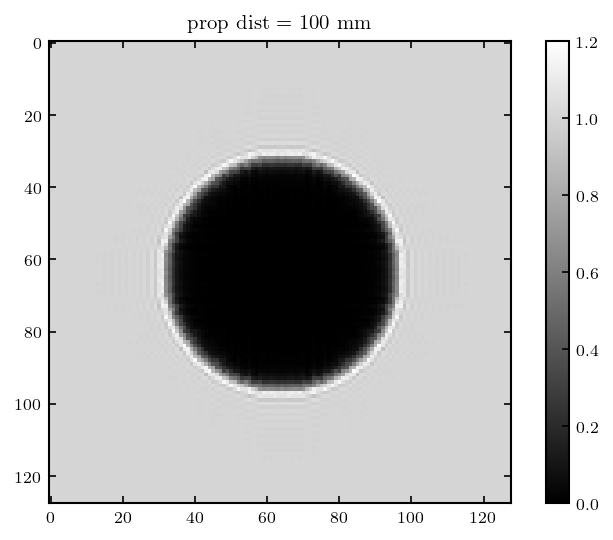

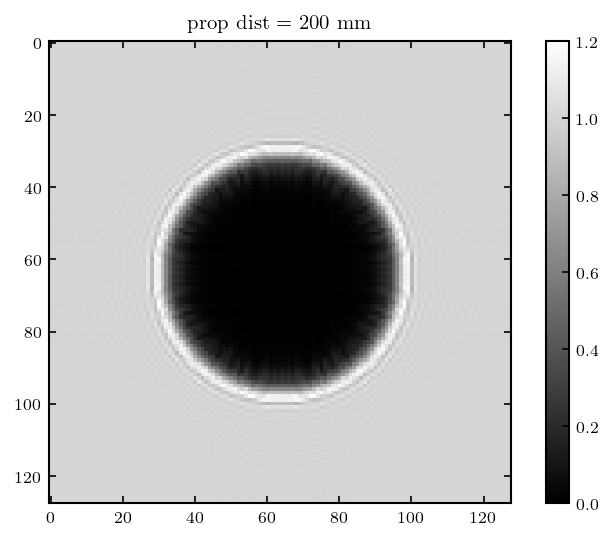

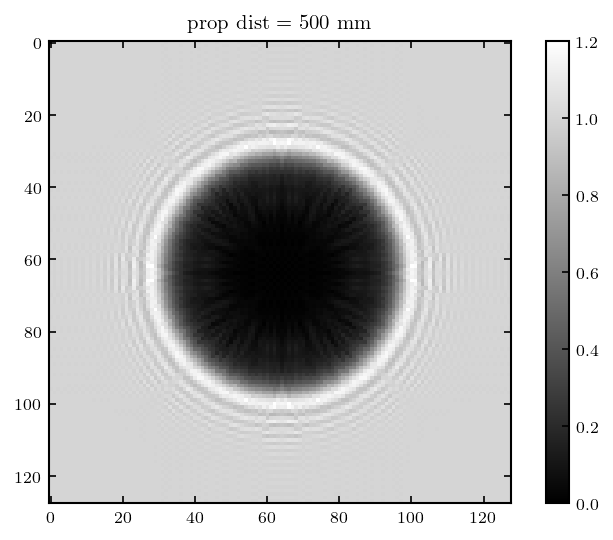

In [7]:
# let's use a 128^3 image with 0.001mm pixels and 0.032mm-radius sphere.
Nx, Ny, Nz = 128, 128, 128
dx, dy, dz = 0.001, 0.001, 0.001
Nx_radius = int(0.032/dx)           # radius in num. pixels
object = get_sphere(Nx, Nx_radius)

for prop_dist in [100, 200, 500]:
    # modulate through the object
    f_obj = modulate_wave(1.0, wavelen, object, dz, delta_ids, beta_ids)
    
    # propagate to the detector
    signal = propagate_wave(f_obj, prop_dist, wavelen, dx, dy)
    
    # view signal
    fig, ax = plt.subplots(1,1,figsize=[6,4])
    ax.set_title(f'prop dist = {prop_dist} mm')
    m = ax.imshow(signal, vmin=0, vmax=1.2)
    fig.colorbar(m, ax=ax)
    plt.show()
